In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import example_Ising_loader as loader


params = {'mathtext.fontset' : 'stix',
          'font.family'      : 'sans-serif',
          'font.sans-serif':['Helvetica'],
          'font.size'        : 9,   
          'text.usetex'      : True,
          'text.latex.preamble':r"""
                  \usepackage{type1cm}
                  \usepackage{amssymb}
                  \usepackage{amsmath}
                  \usepackage[varg]{txfonts}
                  \usepackage{newtxtext}
                  \usepackage{bm}
                  \usepackage{helvet}
                  \usepackage{tikz}
                  \usepackage{sansmath}
                  \sansmath
                  \newcommand{\nosans}[1]{\unsansmath #1\sansmath}
                  """,
        "lines.linewidth": 1.0, # default=1.5
        "axes.labelpad": 1.5, # default=4.0
        "xtick.major.pad": 2.0, # default=3.5
        "ytick.major.pad": 2.0, # default=3.5
        "xtick.bottom": True,
        "ytick.left": True}
plt.rcParams.update(params)


mc = {"red": "tomato",
      "blue": "dodgerblue",
      "green": 'mediumseagreen'}

In [ ]:
# ===== parameters =====
N = 15 # The following code assumes N=15
i = 100 # index of lambda
K_list = loader.K_list

perturb_ratio = 1.02
system_name_all = ["ferromagnetic", "antiferromagnetic-YZ"]


# ===== Load data =====
parent_folder = 'data-others/'

df1 = pd.read_csv(f"{parent_folder}/example_Ising_response_{system_name_all[0]}_N={N}_i={i}_delta={perturb_ratio}.txt", sep='\t')
df2 = pd.read_csv(f"{parent_folder}/example_Ising_response_{system_name_all[1]}_N={N}_i={i}_delta={perturb_ratio}.txt", sep='\t')

df_load_all = [df1, df2]
M_all = [15, 15+22]

# ===== Deform dataframes =====
df_all = []

for df, M in zip(df_load_all, M_all):
    df = pd.pivot(df, columns="mu_paper", values="response", index=["seed_idx", "K"])
    df = abs(df)  
    df = df.rename(columns={mu: f'mu={mu}' for mu in range(M)})
    df.reset_index(inplace=True)

    df_all.append(df)

In [3]:
# ===== Basis information for panel (a) =====
# ordering of the basis used in the paper
basis_order_paper = [(0,), (5,), (1,), (10,), (6,), (2,), (11,), (7,), (3,), 
                 (12,), (8,), (4,), (13,), (9,), (14,),
                 (0, 5), (0, 1), (5, 10), (5, 6), (1, 6), (1, 2), 
                 (10, 11), (6, 11), (6, 7), (2, 7), (2, 3), 
                 (11, 12), (7, 12), (7, 8), (3, 8), (3, 4), 
                 (12, 13), (8, 13), (8, 9), (4, 9), (13, 14), (9, 14)]

# position on the figure
site_pos = [np.array([i, j]) for i in range(3) for j in range(5)]
basis_pos = []
for p1, in basis_order_paper[:15]:
    basis_pos.append(site_pos[p1])
for p1, p2 in basis_order_paper[15:]:
    basis_pos.append((site_pos[p1] + site_pos[p2]) / 2)

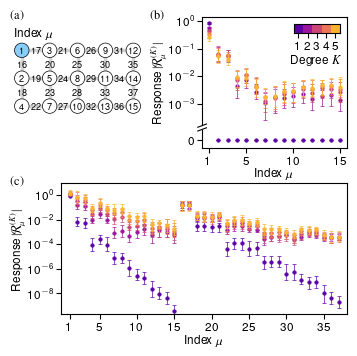

In [4]:
# ===== Create figure =====
aspect_ratio = 3.4/3.4
fig = plt.figure(figsize=(3.4, 3.4*aspect_ratio))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[0.8, 1])
ax0 = plt.subplot(gs[0,:])
ax00 = plt.subplot(gs[0,0])
ax0.set_axis_off()
ax00.set_axis_off()
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,:])

gs_minor = mpl.gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,1], hspace=0.0, 
                                                height_ratios=[0.9, 0.04, 0.15])
ax1_main = plt.subplot(gs_minor[0])
ax1_zero = plt.subplot(gs_minor[2])
ax_all = [ax1_main, ax2]

errorbar_kwargs = dict(marker='o', markersize=2.5, lw=0.5, capsize=1.3, capthick=0.5, markeredgewidth=0.5, ls='none')
cmap_K_norm = mpl.colors.Normalize(vmin=np.min(K_list), vmax=np.max(K_list)+1)
cmap_K = mpl.cm.ScalarMappable(norm=cmap_K_norm, cmap=mpl.cm.plasma).to_rgba


# ===== Plot =====
for ax, df, M in zip(ax_all, df_all, M_all):
    columns = ['mu=' + str(mu) for mu in range(M)]

    for K in [1,2,3,4,5]:
        median = df[df['K'] == K][columns].apply(lambda x: np.quantile(x, 0.5), axis=0).values
        lower = median - df[df['K'] == K][columns].apply(lambda x: np.quantile(x, 0.25), axis=0).values
        upper = df[df['K'] == K][columns].apply(lambda x: np.quantile(x, 0.75), axis=0).values - median

        mu_array = np.arange(1, M+1)
        mask = (median > 1e-14)
        ax.errorbar(mu_array[mask], median[mask], yerr=[lower[mask], upper[mask]], color=cmap_K(K), **errorbar_kwargs, zorder=K)

        if K == 1 and M == N:
            mask = (median < 1e-14)
            ax1_zero.errorbar(mu_array[mask], median[mask], yerr=[lower[mask], upper[mask]], color=cmap_K(K), **errorbar_kwargs, zorder=K)

    ax.set_yscale('log')
    ax.set_yticks([], minor=True)

# Adjust x-axis
ax1_zero.set_xlim(ax1_main.get_xlim())
ax1_zero.set_xticks([1, 5, 10, 15]) 
ax2.set_xticks([1, 5, 10, 15, 20, 25, 30, 35])
ax2.set_xlim(1-1.1, 37+1.1)
ax1_zero.set_xlabel(r'Index \nosans{$\mu$}')
ax2.set_xlabel(r'Index \nosans{$\mu$}')

# Adjust y-axis
ax1.set_ylim(1e-4, None)
ax2.set_ylim(2*1e-10, None)
ylabel_text = r'Response \nosans{$\vert\mathcal{R}_{\mu}^{(K)}\vert$}'
ax1_main.set_ylabel(ylabel_text, labelpad=2, y=0.4)
ax2.set_ylabel(ylabel_text, labelpad=2)

# Adjust double y-axis
ax1_zero.set_ylim(-1e-10, 1.3e-10)
ax1_zero.set_yticks([0])

for direction in ['right', 'top', 'bottom']:
    ax1_main.spines[direction].set_visible(False)
    ax1_zero.spines[direction].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1_main.set_xticks([])

sep_x, sep_y, sep_offset1, sep_offset2 = 0.03, 0.015, 0.005, 0.04
ax1_main.plot((-sep_x, sep_x), (-sep_y-sep_offset1, sep_y-sep_offset1), transform=ax1_main.transAxes, color="k", clip_on=False, lw=0.8)
ax1_main.plot((-sep_x, sep_x), (-sep_y-sep_offset2, sep_y-sep_offset2), transform=ax1_main.transAxes, color="k", clip_on=False, lw=0.8)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zorder(1)
ax1.patch.set_visible(False)
ax1_zero.patch.set_visible(False)

# ===== Add layout =====
for idx, pos in enumerate(basis_pos):
    ax00.text(pos[1], -pos[0]-0.025, str(idx+1), ha='center', va='center', fontsize=7, transform=ax00.transData)
ax00.text(-0.25, 0.6, r'Index \nosans{$\mu$}', fontsize=9, ha='left', va='center', transform=ax00.transData)
ax00.set_xlim(2.5, 4.5)
ax00.set_ylim(-3.5, 1.2) # Change this to move vertically.
ax00.set_aspect('equal', adjustable='box', anchor='C')

for ci in range(3):
    for cj in range(5):
        facecolor = 'lightskyblue' if (ci, cj) == (0, 0) else 'white'
        c = mpl.patches.Circle(xy=(cj, -ci), radius=0.26, fc=facecolor, ec='k', lw=0.5, clip_on=False, transform=ax00.transData, zorder=-5)
        ax00.add_patch(c)

        if ci != 0:
            ax00.plot([cj, cj], [-ci+1, -ci], color='lightgray', lw=2.5, clip_on=False, transform=ax00.transData, zorder=-6)
        if cj != 0:
            ax00.plot([cj-1, cj], [-ci, -ci], color='lightgray', lw=2.5, clip_on=False, transform=ax00.transData, zorder=-6)
                      
# ===== Adjust layout =====
fig.subplots_adjust(left=0.155, right=0.995, top=0.975, bottom=0.10, wspace=0.19, hspace=0.27)
# ax1.add_patch(mpl.patches.Rectangle((0.0, 0.0), width=1.0, height=1.0, color="red", fill=False, transform=fig.transFigure, clip_on=False))

# Add legends
x0, y0, w0, h0 = ax1.get_position().bounds
ax1a = fig.add_axes([x0+w0 - 0.027*5.8, y0+h0 - 0.027*1.8/aspect_ratio, 0.027*5, 0.027/aspect_ratio])
ax1a.imshow([K_list[1:]], cmap=mpl.cm.plasma, norm=cmap_K_norm, aspect='equal') #, extent=[0, len(K_list), 0, 1]
ax1a.set_xticks(np.arange(len(K_list[1:])))
ax1a.set_xticklabels(K_list[1:])
ax1a.set_yticks([])
ax1a.set_xlabel(r'Degree \nosans{$K$}')

# Add titles
ax0.set_title(r'\nosans{$\mathrm{(a)}$}', loc='left', x=-0.18, y=1.005, fontsize=9, verticalalignment='top', pad=5)
ax1.set_title(r'\nosans{$\mathrm{(b)}$}', loc='left', x=-0.36, y=1.005, fontsize=9, verticalalignment='top', pad=5)
ax2.set_title(r'\nosans{$\mathrm{(c)}$}', loc='left', x=-0.18, y=1.005, fontsize=9, verticalalignment='top', pad=5)

fig.savefig(f'example_Ising_perturbation_{system_name_all[0]}-{system_name_all[1]}_N={N}_i={i}_delta={perturb_ratio}.pdf', dpi=1200);